In [3]:
import torch
import multiprocessing
import os

def get_gpu_count():
    return torch.cuda.device_count()

def get_cpu_count():
    return multiprocessing.cpu_count()

if __name__ == "__main__":
    num_gpus = get_gpu_count()
    num_cpus = get_cpu_count()
    print("Number of GPUs (torch.cuda.device_count()):", num_gpus)
    print("Number of CPUs (multiprocessing.cpu_count()):", num_cpus)

print("Number of CPUs (os.cpu_count()):", os.cpu_count())

Number of GPUs (torch.cuda.device_count()): 0
Number of CPUs (multiprocessing.cpu_count()): 8
Number of CPUs (os.cpu_count()): 8


In [33]:
import joblib
import pandas as pd
import math
from math import ceil
import random
import peakutils
import pandas as pd
import contextlib
import torch
import sys
import sbi
import numpy as np
from numpy import fft, ndarray
from scipy.integrate import odeint
from scipy.stats import norm
import matplotlib.pyplot as plt
import os
import seaborn as sns
from pyro.infer.mcmc.api import MCMC
from warnings import warn
from torch import Tensor, split, randint, cat
from typing import Any, Callable, Optional, Tuple, Union, Dict
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm.auto import tqdm, trange
from pyro.infer.mcmc import HMC, NUTS
from sbi.inference import prepare_for_sbi, SNLE, simulate_for_sbi #need SNRE, SNPE in future
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.types import Shape, TorchTransform
from sbi.utils.get_nn_models import (likelihood_nn,)
from sbi.samplers.mcmc import SliceSamplerVectorized
from sbi.samplers.mcmc.slice_numpy import MCMCSampler
from sbi.utils import tensor2numpy

In [53]:
def seed_all_backends(seed: Optional[Union[int, Tensor]] = None) -> None:
    if seed is None:
        seed = int(torch.randint(10_000_000, size=(1,)))
    else:
        # Cast Tensor to int (required by math.random since Python 3.11)
        seed = int(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)
    
    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress
    
    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()

class SliceSampler(MCMCSampler):
    def __init__(self, x, lp_f, max_width=float("inf"), init_width: Union[float, np.ndarray] = 0.05, thin=None, tuning: int = 50, verbose: bool = False,):
        MCMCSampler.__init__(self, x, lp_f, thin, verbose=verbose)
        self.max_width = max_width
        self.init_width = init_width
        self.width = None
        self.tuning = tuning
        
    def _tune_bracket_width(self, rng):
        order = list(range(self.n_dims))
        x = self.x.copy()

        self.width = np.full(self.n_dims, self.init_width)

        tbar = trange(self.tuning, miniters=2, disable=not self.verbose)
        tbar.set_description("Tuning bracket width...")
        for n in tbar:
            # for n in range(int(self.tuning)):
            rng.shuffle(order)
            for i in range(self.n_dims):
                x[i], wi = self._sample_from_conditional(i, x[i], rng)
                self.width[i] += (wi - self.width[i]) / (n + 1)

    def _sample_from_conditional(self, i: int, cxi, rng):
        assert self.width is not None, "Chain not initialized."

        # conditional log prob
        Li = lambda t: self.lp_f(np.concatenate([self.x[:i], [t], self.x[i + 1 :]]))
        wi = self.width[i]

        # sample a slice uniformly
        logu = Li(cxi) + np.log(1.0 - rng.rand())

        # position the bracket randomly around the current sample
        lx = cxi - wi * rng.rand()
        ux = lx + wi
        
        # find lower bracket end
        while Li(lx) >= logu and cxi - lx < self.max_width:
            lx -= wi

        # find upper bracket end
        while Li(ux) >= logu and ux - cxi < self.max_width:
            ux += wi

        # sample uniformly from bracket
        xi = (ux - lx) * rng.rand() + lx

        # if outside slice, reject sample and shrink bracket
        while Li(xi) < logu:
            if xi < cxi:
                lx = xi
            else:
                ux = xi
            xi = (ux - lx) * rng.rand() + lx
       
        return xi, ux - lx
      
def run_fun(SliceSamplerSerial, num_samples, inits, seed, log_prob_fn: Callable, thin: Optional[int] = None, tuning: int = 50, verbose: bool = True, init_width: Union[float, np.ndarray] = 0.01,
            max_width: float = float("inf"), num_workers: int = 1, rng=np.random, show_info: bool = False, logger=sys.stdout) -> np.ndarray:
    np.random.seed(seed)
    posterior_sampler = SliceSampler(inits, lp_f=log_prob_fn, max_width=max_width, init_width=init_width, thin=thin, tuning=tuning, verbose=num_workers == 1 and verbose,)
    
    assert num_samples >= 0, "number of samples can't be negative"

    order = list(range(posterior_sampler.n_dims))
    L_trace = []
    samples = np.empty([int(num_samples), int(posterior_sampler.n_dims)])
    logger = open(os.devnull, "w") if logger is None else logger

    if posterior_sampler.width is None:
        # logger.write('tuning bracket width...\n')
        posterior_sampler._tune_bracket_width(rng)

    tbar = trange(int(num_samples), miniters=10, disable=not posterior_sampler.verbose)
    tbar.set_description("Generating samples")
    for n in tbar:
        # for n in range(int(n_samples)):
        for _ in range(posterior_sampler.thin):
            rng.shuffle(order)

            for i in order:
                posterior_sampler.x[i], _ = posterior_sampler._sample_from_conditional(i, posterior_sampler.x[i], rng)

        samples[n] = posterior_sampler.x.copy()

        posterior_sampler.L = posterior_sampler.lp_f(posterior_sampler.x)
        # logger.write('sample = {0}, log prob = {1:.2}\n'.format(n+1, self.L))

        if show_info:
            L_trace.append(posterior_sampler.L)

    # show trace plot
    if show_info:
        fig, ax = plt.subplots(1, 1)
        ax.plot(L_trace)
        ax.set_ylabel("log probability")
        ax.set_xlabel("samples")
        plt.show(block=False)

    return samples

def run(SliceSamplerSerial, log_prob_fn: Callable, num_samples: int, init_params: np.ndarray, num_chains: int = 1, thin: Optional[int] = None, verbose: bool = True, num_workers: int = 1,) -> np.ndarray:
    num_chains , dim_samples = init_params.shape
    # Generate seeds for workers from current random state.
    seeds = torch.randint(high=1_000_000, size=(num_chains,))
    for seed in seeds:
        seed_all_backends(seed)
    with tqdm_joblib(tqdm(range(num_chains), disable=not verbose or num_workers == 1, desc=f"""Running {num_chains} MCMC chains with {num_workers} worker{"s" if num_workers>1 else ""}.""", total=num_chains,)):
        all_samples = Parallel(n_jobs=num_workers)(delayed(run_fun)(SliceSamplerSerial, num_samples, initial_params_batch, seed, log_prob_fn)for initial_params_batch, seed in zip(init_params, seeds))
    samples = np.stack(all_samples).astype(np.float32)
    samples = samples.reshape(num_chains, -1, dim_samples)  # chains, samples, dim
    samples = samples[:, :: thin, :]  # thin chains

    # save samples
    return samples

class SliceSamplerSerial:
    def __init__(self, log_prob_fn: Callable, init_params: np.ndarray, num_chains: int = 1, thin: Optional[int] = None, tuning: int = 50, verbose: bool = True, init_width: Union[float, np.ndarray] = 0.01, max_width: float = float("inf"), num_workers: int = 1,):
        self._log_prob_fn = log_prob_fn
        self.x = init_params
        self.num_chains = num_chains
        self.thin = thin
        self.tuning = tuning
        self.verbose = verbose
        self.init_width = init_width
        self.max_width = max_width
        self.n_dims = self.x.size
        self.num_workers = num_workers
        self._samples = None

    def get_samples(self, num_samples: Optional[int] = None, group_by_chain: bool = True) -> np.ndarray:
        if self._samples is None:
            raise ValueError("No samples found from MCMC run.")
        # if not grouped by chain, flatten samples into (all_samples, dim_params)
        if not group_by_chain:
            samples = self._samples.reshape(-1, self._samples.shape[2])
        else:
            samples = self._samples

        # if not specified return all samples
        if num_samples is None:
            return samples
        # otherwise return last num_samples (for each chain when grouped).
        elif group_by_chain:
            return samples[:, -num_samples:, :]
        else:
            return samples[-num_samples:, :]

##############################################################################################################################
        
def _maybe_use_dict_entry(default: Any, key: str, dict_to_check: Dict) -> Any:
    attribute = default if key not in dict_to_check.keys() else dict_to_check[key]
    return attribute

def _get_initial_params(proposal, init_strategy: str, num_chains: int, num_workers: int, show_progress_bars: bool, **kwargs,) -> Tensor: 
    # Build init function
    init_fn = proposal._build_mcmc_init_fn(proposal.proposal, proposal.potential_fn, transform=proposal.theta_transform, init_strategy=init_strategy, **kwargs,)

    # Parallelize inits for resampling only.
    if num_workers > 1 and (init_strategy == "resample" or init_strategy == "sir"):
        def seeded_init_fn(seed):
            torch.manual_seed(seed)
            return init_fn()

        seeds = torch.randint(high=10_000_000, size=(num_chains,))

        # Generate initial params parallelized over num_workers.
        with tqdm_joblib(tqdm(range(num_chains), disable=not show_progress_bars, desc=f"""Generating {num_chains} MCMC inits with {num_workers} workers.""", total=num_chains,)):
            initial_params = torch.cat(Parallel(n_jobs=num_workers)(delayed(seeded_init_fn)(seed) for seed in seeds))
    else:
        initial_params = torch.cat([init_fn() for _ in range(num_chains)])
    return initial_params
    
def _slice_np_mcmc(proposal, num_samples: int, potential_function: Callable, initial_params: Tensor, thin: int, warmup_steps: int, vectorized: bool = False, num_workers: int = 1, init_width: Union[float, ndarray] = 0.01, show_progress_bars: bool = True,) -> Tensor:
    num_chains, dim_samples = initial_params.shape
        
    if not vectorized:
        SliceSamplerMultiChain = SliceSamplerSerial
    else:
        SliceSamplerMultiChain = SliceSamplerVectorized

    posterior_sampler = SliceSamplerMultiChain(init_params=tensor2numpy(initial_params), log_prob_fn=potential_function, num_chains=num_chains, thin=thin, verbose=show_progress_bars, num_workers=num_workers, init_width=init_width,)
    warmup_ = warmup_steps * thin
    num_samples_ = ceil((num_samples * thin) / num_chains)
    # Run mcmc including warmup
    samples = run(posterior_sampler, log_prob_fn=potential_function, num_samples = (warmup_ + num_samples_), init_params = tensor2numpy(initial_params))
    samples = samples[:, warmup_steps:, :]  # discard warmup steps
    samples = torch.from_numpy(samples)  # chains x samples x dim

    # Save posterior sampler.
    proposal._posterior_sampler = posterior_sampler

    # Save sample as potential next init (if init_strategy == 'latest_sample').
    proposal._mcmc_init_params = samples[:, -1, :].reshape(num_chains, dim_samples)

    # Collect samples from all chains.
    samples = samples.reshape(-1, dim_samples)[:num_samples, :]
    assert samples.shape[0] == num_samples
    return samples.type(torch.float32).to(proposal._device)

def sample_my_fun(proposal, sample_shape: Shape = torch.Size(), x: Optional[Tensor] = None, method: Optional[str] = None, thin: Optional[int] = None, warmup_steps: Optional[int] = None, num_chains: Optional[int] = None, init_strategy: Optional[str] = None, init_strategy_parameters: Optional[Dict[str, Any]] = None,
                   init_strategy_num_candidates: Optional[int] = None, mcmc_parameters: Dict = {}, mcmc_method: Optional[str] = None, sample_with: Optional[str] = None, num_workers: Optional[int] = None, show_progress_bars: bool = True,) -> Tensor:
    
    proposal.potential_fn.set_x(proposal._x_else_default_x(x))

    # Replace arguments that were not passed with their default.
    method = proposal.method if method is None else method
    thin = proposal.thin if thin is None else thin
    warmup_steps = proposal.warmup_steps if warmup_steps is None else warmup_steps
    num_chains = proposal.num_chains if num_chains is None else num_chains
    init_strategy = proposal.init_strategy if init_strategy is None else init_strategy
    num_workers = proposal.num_workers if num_workers is None else num_workers
    init_strategy_parameters = (proposal.init_strategy_parameters if init_strategy_parameters is None else init_strategy_parameters)

    if init_strategy_num_candidates is not None:
        warn("""Passing `init_strategy_num_candidates` is deprecated as of sbi v0.19.0. Instead, use e.g.,`init_strategy_parameters={"num_candidate_samples": 1000}`""")
        proposal.init_strategy_parameters["num_candidate_samples"] = (init_strategy_num_candidates)
    if sample_with is not None:
        raise ValueError(f"You set `sample_with={sample_with}`. As of sbi v0.18.0, setting `sample_with` is no longer supported. You have to rerun `.build_posterior(sample_with={sample_with}).`")
    if mcmc_method is not None:
        warn("You passed `mcmc_method` to `.sample()`. As of sbi v0.18.0, this is deprecated and will be removed in a future release. Use `method` instead of `mcmc_method`.")
        method = mcmc_method
    if mcmc_parameters:
        warn("You passed `mcmc_parameters` to `.sample()`. As of sbi v0.18.0, this is deprecated and will be removed in a future release. Instead, pass the variable to `.sample()` directly, e.g. `posterior.sample((1,), num_chains=5)`.")
    # The following lines are only for backwards compatibility with sbi v0.17.2 or older.
    m_p = mcmc_parameters  # define to shorten the variable name
    method = _maybe_use_dict_entry(method, "mcmc_method", m_p)
    thin = _maybe_use_dict_entry(thin, "thin", m_p)
    warmup_steps = _maybe_use_dict_entry(warmup_steps, "warmup_steps", m_p)
    num_chains = _maybe_use_dict_entry(num_chains, "num_chains", m_p)
    init_strategy = _maybe_use_dict_entry(init_strategy, "init_strategy", m_p)
    proposal.potential_ = proposal._prepare_potential(method)  # type: ignore

    initial_params = _get_initial_params(proposal, init_strategy, num_chains, num_workers, show_progress_bars, **init_strategy_parameters,)
    num_samples = torch.Size(sample_shape).numel()

    track_gradients = method in ("hmc", "nuts")
    with torch.set_grad_enabled(track_gradients):
        if method in ("slice_np", "slice_np_vectorized"):
            transformed_samples = _slice_np_mcmc(proposal, num_samples=num_samples, potential_function=proposal.potential_, initial_params=initial_params, thin=thin, warmup_steps=warmup_steps, vectorized=(method == "slice_np_vectorized"), num_workers=num_workers, show_progress_bars=show_progress_bars,)
        elif method in ("hmc", "nuts", "slice"):
            transformed_samples = _pyro_mcmc(proposal, num_samples=num_samples, potential_function=proposal.potential_, initial_params=initial_params, mcmc_method=method, thin=thin, warmup_steps=warmup_steps, num_chains=num_chains, show_progress_bars=show_progress_bars,)
        else:
            raise NameError

    samples = proposal.theta_transform.inv(transformed_samples)

    return samples.reshape((*sample_shape, -1))  # type: ignore

#######################################################################################################################################

def simulator_seeded(simulator: Callable, theta: Tensor, seed: int) -> Tensor:
    import torch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    with torch.random.fork_rng(devices=[]):
        torch.manual_seed(seed)
        return simulator(theta)

def simulate_in_batches(simulator: Callable, theta: Tensor, sim_batch_size: int = 1, num_workers: int = 1 , seed: Optional[int] = None, show_progress_bars: bool = True, ) -> Tensor:
    num_sims, *_ = theta.shape
    seed_all_backends(seed)
    if num_sims == 0:
        x = torch.tensor([])
    elif sim_batch_size is not None and sim_batch_size < num_sims:
        batches = split(theta, sim_batch_size, dim=0)
        
        if num_workers != 1:
            batch_seeds = randint(high=1_000_000, size=(len(batches),))
            with tqdm_joblib(tqdm(batches, disable=not show_progress_bars, total = len(batches), desc=f"Running {num_sims} simulations in {len(batches)} batches ({num_workers} cores)",)) as _:
                simulation_outputs = Parallel(n_jobs=num_workers)(delayed(simulator_seeded)(simulator, batch, batch_seed) for batch, batch_seed in zip(batches, batch_seeds))
        else:
            pbar = tqdm(total=num_sims, disable=not show_progress_bars, desc=f"Running {num_sims} simulations.", )
            with pbar:
                simulation_outputs = []
                for batch in batches:
                    simulation_outputs.append(simulator_seeded(simulator, batch, seed))
                    pbar.update(sim_batch_size)
        x = cat(simulation_outputs, dim=0)
    else:
        x = simulator(theta)
    return x

def simulate_for_sbi(round_idx: int, simulator: Callable, proposal: Any, num_simulations: int, num_workers: int = 1, simulation_batch_size: int = 1, seed: Optional[int] = None, show_progress_bar: bool = True)-> Tuple[Tensor, Tensor]:
    if round_idx == 0:
        theta = proposal.sample((num_simulations,))
    else:
        theta = sample_my_fun(proposal, (num_simulations,), num_workers = num_workers, num_chains = 4, method = 'slice_np_vectorized') # because only in first round proposal is boxuniform, then it is mcmcposterior object
    
    x = simulate_in_batches(simulator=simulator, theta=theta, sim_batch_size=simulation_batch_size, num_workers=num_workers, seed=seed, show_progress_bars=show_progress_bar)
    
    return theta, x

In [ ]:
#for multiple sets of parameters

#prior according to no. of parameters
#number of rounds customise
#number of simulations customise
#algorithm SNRE/SNLE
# Have not checked SNPE syntax

In [64]:
def run_sbi(algorithm, num_rounds, num_simulations,num_parameters,true_param_values):
    if num_parameters == 3:
        headers = ["k1", "k2", "k3"]          # parameters to be inferred
        prior = utils.BoxUniform(low=10**0.02 * torch.ones(3), high=250. * torch.ones(3))
        a1,a2,a3,g1,g2,g3,n1,n2,n3,b1,b2,b3,dm1,dm2,dm3,dp1,dp2,dp3=true_param_values[3:]
    elif num_parameters==6:
        headers = ["k1","k2","k3","a1","a2","a3"]          # parameters to be inferred
        prior = utils.BoxUniform(low=torch.tensor([10**-2,10**-2,10**-2,20.,20.,20.]),high=torch.tensor([250.,250.,250.,40.,40.,40.]))
        g1,g2,g3,n1,n2,n3,b1,b2,b3,dm1,dm2,dm3,dp1,dp2,dp3=true_param_values[6:]
    elif num_parameters==15:
        headers= ['k1','k2','k3','a1','a2','a3','g1','g2','g3','n1','n2','n3','b1','b2','b3']
        prior= utils.BoxUniform(low=torch.tensor([10**-2,10**-2,10**-2,20.,20.,20.,0.,0.,0.,1.,1.,1.,5.,5.,5.]),high=torch.tensor([250.,250.,250.,40.,40.,40.,5.,5.,5.,5.,5.,5.,50.,50.,50.])) 
        dm1,dm2,dm3,dp1,dp2,dp3=true_param_values[15:]
    # To parallelise, set number of CPUs to be used.
    simulation_batch_size = 8
    # run os.cpu_count() to see number of available CPUs
    CPUs_to_use = 8 #change according to the computer we are using
    num_CPU_to_use=CPUs_to_use-2
    # FOR MCMC
    num_mcmc_iterations = 10_000 # total in all chains
    interval_to_calculate_acceptance_rate = 100
    burn_in_fraction = 0.3
    num_chains = 4
    #timesteps
    t = np.linspace(0, 100, 100)
    
    def model(variables, t, params): #params are the values passed in from simulate for sbi e.g. 3ks
        m1, p1, m2, p2, m3, p3 = variables
        param=['k1','k2','k3','a1','a2','a3','g1','g2','g3','n1','n2','n3','b1','b2','b3','dm1','dm2','dm3','dp1','dp2','dp3'] #is there way to change this
        param_values=np.concatenate([params, true_param_values[num_parameters:]])
        param_dict = dict(zip(param, param_values))
        k1, k2, k3, a1, a2, a3, g1, g2, g3, n1, n2, n3, b1, b2, b3, dm1, dm2, dm3, dp1, dp2, dp3 = [param_dict[key] for key in param]
        #for now we are setting a, g, n, b dm, dp to be constant
        dm1dt = -dm1*m1 + (a1 / (1 + ((1/k1) * p2)**n1)) + g1
        dp1dt = (b1*m1) - (dp1*p1)
        dm2dt = -dm2*m2 + (a2 / (1 + ((1/k2) * p3)**n2)) + g2
        dp2dt = (b2*m2) - (dp2*p2)
        dm3dt = -dm3*m3 + (a3 / (1 + ((1/k3) * p1)**n3)) + g3
        dp3dt = (b3*m3)-(dp3*p3)
        return np.array([dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]).flatten()

    def solve_ode(params):
        initial_conditions = np.array([0, 2, 0, 1, 0, 3])
        solution = odeint(model, initial_conditions, t=np.linspace(0,100,100), args=(params,)) # The initial value point should be the first element of this sequence
        return solution.flatten()

    true_solutions = solve_ode(true_param_values)
    simulator, prior = prepare_for_sbi(solve_ode, prior)

    inference = algorithm(prior = prior) # Initialise inference
    posteriors = [] # Empty list to contain posterior after each round
    proposal = prior # For the first round proposal = prior, then updated (sequentiality)

    for _ in range(num_rounds):
        print(f"Round {_+1}")
        theta, x = simulate_for_sbi(_, simulator, proposal, num_simulations, simulation_batch_size, num_CPU_to_use)
        density_estimator = inference.append_simulations(theta, x).train()
        posterior = inference.build_posterior(density_estimator)
        posteriors.append(posterior)
        proposal = posterior.set_default_x(true_solutions)
        print("\n")


    posterior_samples = sample_my_fun(posterior, (100,), num_chains = 1) # sample to plot the posteriors

    _ = analysis.pairplot(posterior_samples, figsize=(8, 8), labels=headers)

    plt.savefig(f'{num_parameters}p-{num_rounds}*{num_simulations}.png')
    
    posterior_samples_df = pd.DataFrame(data=posterior_samples, columns=headers)
    posterior_samples_df.to_csv(f'{num_parameters}p-{num_rounds}*{num_simulations}_posterior_samples.csv')


Round 1


Running 10 simulations in 2 batches (8 cores): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


 Neural network successfully converged after 126 epochs.



Generating samples: 100%|██████████| 1100/1100 [01:31<00:00, 12.05it/s]


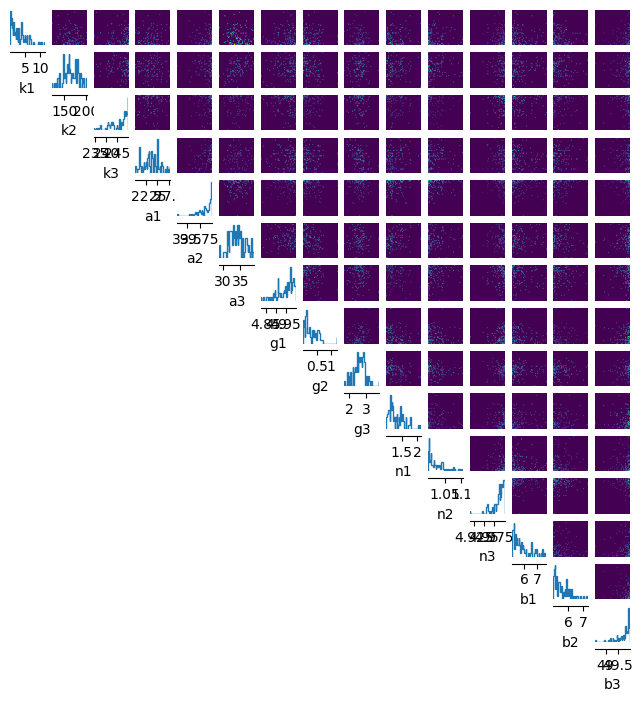

In [65]:
true_params=[38.94801652652866,193.4015439096185,52.24130352947285,30.52123007653054,39.231588311273846,34.86007101736975,0.1902661176643755,0.28113643328037285,0.8181176651249633,4.758094367378883,1.985417765709296,4.910007465597671,24.68491191280538,29.42387320898578,41.04934603816582,1.1977430229572492,1.5302375124759988,1.5608364378206137,0.7747339528650133,0.7511393265314563,0.7528339378453786]
run_sbi(algorithm=SNLE,num_rounds=1,num_simulations=10,num_parameters=15,true_param_values=true_params)



In [71]:
import pandas as pd

df = pd.read_csv('oscillatory_parameters.csv') #assuming the file is in the same directory as the notebook
true_params_list = np.array(df)

In [ ]:
for true_params in true_params_list:
    for algorithm in [SNLE, SNRE]:
            for num_parameters in [3, 6, 15]:
                run_sbi(algorithm, num_rounds=5, num_simulations=3000, num_parameters, true_params)
                run_sbi(algorithm, num_rounds=10, num_simulations=1500, num_parameters, true_params)